### Initialization of code

In [1]:
#Initialize and validate GPU on torch

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce GTX 1650 Ti


device(type='cuda', index=0)

In [57]:
#Import necessary libraries

import os
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data

from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz


### Initialization of dataset

In [3]:
#Establish dataset division into train, validation, and test

base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Model Definition

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        #Convolution + relu + pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        #Flattenning
        x = x.view(-1, 128 * 7 * 7)

        # Fully connected layers and sigmoid
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

model = ConvNet()
model.to(device)
print("Convolutional Neural Network Model Definition:")
print(model)

Convolutional Neural Network Model Definition:
ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


### Training Parameters

In [5]:
batch_size = 20
epochs = 30
steps_per_epoch = 100
validation_steps = 50

### Data Preprocessing

In [6]:
#Perform resizing and scaling of images
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

#Create Dataloaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for data_batch, labels_batch in train_loader:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: torch.Size([20, 3, 150, 150])
labels batch shape: torch.Size([20])


### Model Training

In [7]:
##Define Loss function and optimizer

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [98]:
#Store metrics for later
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

#Training loop
for epoch_num, epoch in enumerate(range(epochs)):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_steps = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze()

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds == labels.data)

        train_steps += 1
        if train_steps >= steps_per_epoch:
            break

    epoch_loss = running_loss / (train_steps * batch_size)
    epoch_acc = running_corrects.double() / (train_steps * batch_size)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_steps = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()

            # Compute loss
            loss = criterion(outputs, labels)

            # Statistics
            val_running_loss += loss.item() * inputs.size(0)
            preds = (outputs >= 0.5).float()
            val_running_corrects += torch.sum(preds == labels.data)

            val_steps += 1
            if val_steps >= validation_steps:
                break

    val_loss = val_running_loss / (val_steps * batch_size)
    val_acc = val_running_corrects.double() / (val_steps * batch_size)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} - '
          f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

Epoch 1/30 - Train Loss: 0.4686 Train Acc: 0.7950 - Val Loss: 0.5583 Val Acc: 0.7310
Epoch 2/30 - Train Loss: 0.3758 Train Acc: 0.8370 - Val Loss: 0.6213 Val Acc: 0.7000
Epoch 3/30 - Train Loss: 0.3518 Train Acc: 0.8520 - Val Loss: 0.5750 Val Acc: 0.7370
Epoch 4/30 - Train Loss: 0.3476 Train Acc: 0.8505 - Val Loss: 0.5496 Val Acc: 0.7280
Epoch 5/30 - Train Loss: 0.3248 Train Acc: 0.8685 - Val Loss: 0.5575 Val Acc: 0.7350
Epoch 6/30 - Train Loss: 0.3160 Train Acc: 0.8665 - Val Loss: 0.5798 Val Acc: 0.7440
Epoch 7/30 - Train Loss: 0.2973 Train Acc: 0.8750 - Val Loss: 0.6053 Val Acc: 0.7400
Epoch 8/30 - Train Loss: 0.2804 Train Acc: 0.8875 - Val Loss: 0.6616 Val Acc: 0.7070
Epoch 9/30 - Train Loss: 0.2654 Train Acc: 0.8895 - Val Loss: 0.5896 Val Acc: 0.7400
Epoch 10/30 - Train Loss: 0.2535 Train Acc: 0.9050 - Val Loss: 0.6143 Val Acc: 0.7380
Epoch 11/30 - Train Loss: 0.2330 Train Acc: 0.9120 - Val Loss: 0.7338 Val Acc: 0.7140
Epoch 12/30 - Train Loss: 0.2239 Train Acc: 0.9120 - Val Loss: 

In [99]:
torch.save(model.state_dict(), "convnet_model.pth")

### Vizualization of training and validation metrics

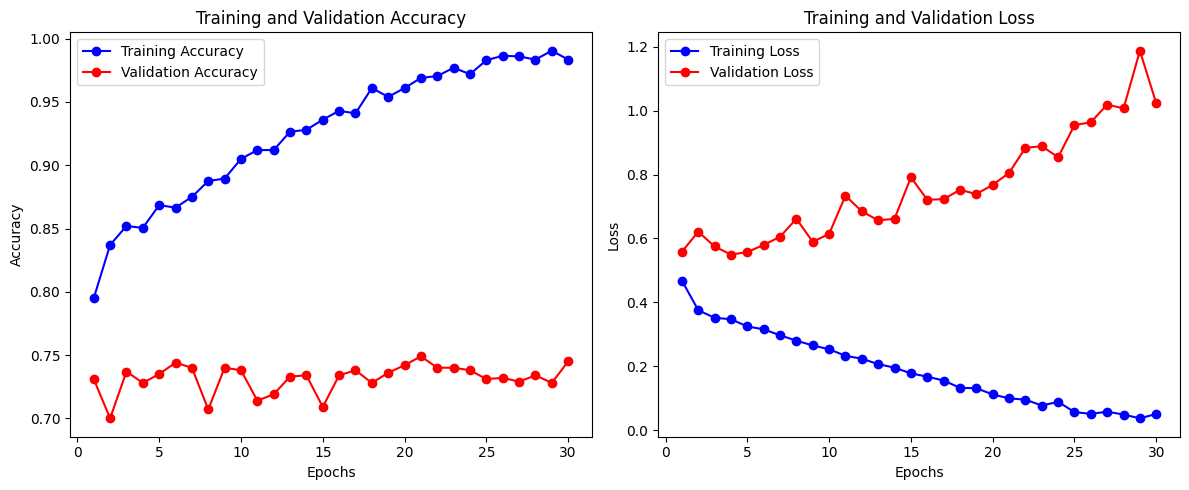

In [100]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model Evaluation on the test dataset

Test Loss: 0.9697755485773086
Test Accuracy: 76.4%

True Negatives:  370
False Positives:  130
False Negatives:  106
True Positives:  394
Total Detections  500


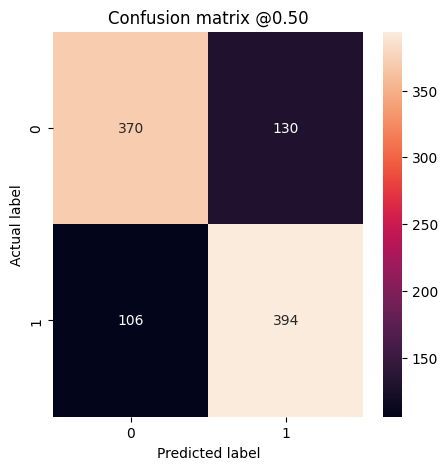

In [37]:
#Create the test dataset from the test directory
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Fucntion to plut the confusion matrix using sns heatmap and the test predictions
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Detections ', np.sum(cm[1]))

#Test mode
model.eval()

#Predict the test images and store the statistics
test_running_loss = 0.0
test_running_corrects = 0
test_steps = 0

all_preds = []
all_labels = []

for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    # Forward pass
    outputs = model(inputs)
    outputs = outputs.squeeze()

    # Compute loss
    loss = criterion(outputs, labels)

    # Statistics
    test_running_loss += loss.item() * inputs.size(0)
    preds = (outputs >= 0.5).float()
    test_running_corrects += torch.sum(preds == labels.data)

    all_preds.extend(preds.cpu().detach().numpy())
    all_labels.extend(labels.cpu().detach().numpy())

    test_steps += 1

#Compute and print the test loss and accuracy
test_loss = test_running_loss / (test_steps * batch_size)
test_acc = test_running_corrects.double() / (test_steps * batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc*100}%\n")

#Display the confusion matrix, along with the individual count of each section
plot_cm(np.array(all_labels), np.array(all_preds))

### Feature Attribution

Consider a convolutional neural network based on the above model. Given a prediction performed by this model, feature attribution allows us to understand the contribution made by an individual pixel of an input image toward this prediction.  
Feature attribution allows us to understand which parts of the image were most important w.r.t. any trained model (either a CNN or any neural network), and this gives us a visual explanation for a CNN prediction.  

More formally, from the paper (Sundararajan et al),  
Suppose we have a function F $(R^n -> [0, 1])$ that represents a deep network, and an input $x = (x_1, . . . , x_n) ∈ R^n$.  
An attribution of the prediction at input $x$ relative to a baseline input $x'$ is a vector
$A_F(x, x') = (a_1, . . . , a_n) ∈ R^n$ where $a_i$ is the contribution of $x_i$ to the prediction F(x).  
An example of feature attribution using integrated gradients is demonstrated below:

### Integratated Gradients

Integrated Gradients is a method for feature attribution in neural networks that attributes the prediction of a deep learning network to its input features.  
To understand this better, consider the example of the convolutional neural network trained above.  
The below code loads the model from the saved path:


In [50]:
#Load the previously trained model
model = ConvNet()
model.load_state_dict(torch.load('convnet_model.pth', map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_1065/1113272548.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('convnet_model.pth', map_location=device))


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

From the trained dataset, lets pick a random image of a cat. We can also transform the image into the format required by the model.  
Below is the code displaying the image of the randomly picked cat:

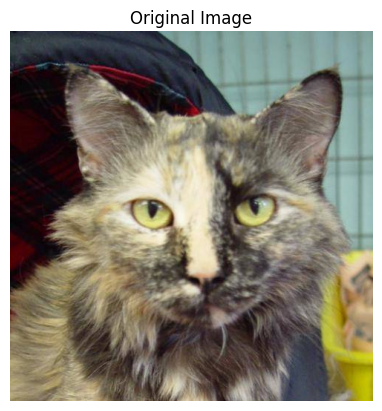

In [51]:
#Read image and apply necessary transforms that the model expects
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

image_path = 'dogscats/subset/train/cats/cat.10.jpg'
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

#Show the image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

Now lets run this example image through our trained model to see what it predicts.  
Note: The model output is a sigmoid with 0 representing cat and 1 representing dog.

In [52]:
#Predict output of test image
def predict(input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
    return output


output = predict(input_tensor)
pred = (output >= 0.5).float().item()

#Show what the prediction means
idx_to_class = {0: 'Cat', 1: 'Dog'}
pred_class = idx_to_class[pred]
print(f"Prediction Score: {output.float().item()}")
print(f"Actual Class: 'Cat' ; Predicted Class: '{pred_class}'")

Prediction Score: 0.0009550013928674161
Actual Class: 'Cat' ; Predicted Class: 'Cat'


Our model was able to correctly identify and predict cat with almost full confidence!  
However, we are not sure of the model is focussing on the correct and important pixels in the input image for making a prediction.  
What if the model is only making a guess based on the background (happens when using a non-diverse dataset)?  
To understand this better, we will be using the Integrated Gradients method to highlight the important pixels that contributed toward this prediction.

**Theory behind Integrated Gradients:**  
Given our model above, suppose that we have a baseline image - a black image with all pixel values = 0.  
The method interpolates this baseline input gradually up to the actual image across multiple steps.  
For each step, the gradient of the output (for the target class) with respect to the input features is calculated.  
The gradients are accumulated and then finally integrated over the path (from baseline to input) to determine the contribution of each pixel toward the final prediction.  
The result is a set of attribution scores for each pixel, where higher values indicate that the pixel had a larger influence on the model's decision.

As part of this example, we will be using the Captum Library in PyTorch:  

Steps Performed:  
1. We will initialize the Integrated Gradients explainer using the above model - `ig = IntegratedGradients(model)`.  
This will give us the instance of the explainer.  

2. We perform attribution using `ig.attribute()` by providing the following arguments:  
i. `inputs=input_tensor` representing the image of the randomly picked cat as a tensor input format required by the model.  
ii. `target=0` representing that our desired output is '0' or 'cat'.  
iii. `n_steps=200` representing the number of steps required for interpolation between the input and baseline image.

In [53]:
#Initialize the attribution algorithm with the model
ig = IntegratedGradients(model)
attributions_ig = ig.attribute(inputs=input_tensor, target=0, n_steps=200)

print(f"Input shape:\n {input_tensor.shape}")
print(f"Attribution shape:\n {attributions_ig.shape}")

Input shape:
 torch.Size([1, 3, 150, 150])
Attribution shape:
 torch.Size([1, 3, 150, 150])


The attribution result is the same shape as the input image where each value corresponds to the attribution score of that pixel toward the model prediction.  

Now, to vizualize the attribution with respect to the input image we will perform the following steps:  
1. Display the original image for comparison using `viz.visualize_image_attr()` and providing the numpy version of the input.  
2. Create a colour map using `LinearSegmentedColormap.from_list()` to gradually increase from white representing low scores to blue representing high scores.  
3. Convert the images from pytorch tensors into numpy arrays and transpose the dimentions into (height, width, channels) format.  
4. Now we vizualize the attribution matrix in the form of an image with the above colormap using `viz.visualize_image_attr()` and the following arguments:  
i. `attr=attr_img` is the attribute image  
ii. `original_image=org_img` is the original image  
iii. `method="heat_map"` to indicate heatmap vizualization with each pixel intensity signifying attribution strength.  
iv.  `cmap=default_cmap` indicating the default colormap defined in step 2 to be used as part of the heatmap.  
v.  `show_colorbar=True` indicating that the result should display a legend of the color intensities present in the heatmap.  
vi. `sign="positive"` specifies that we are interested in pixels contributing positively toward the prediction of 'cat'.  

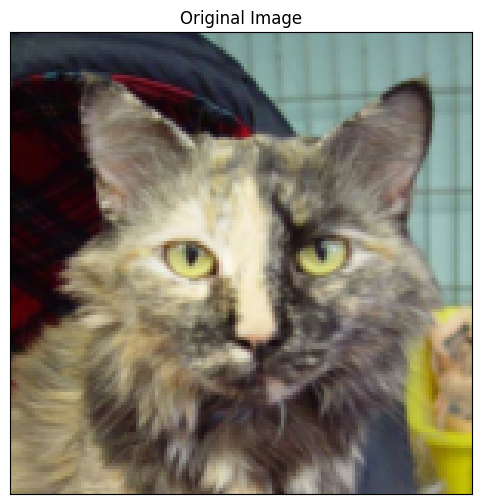

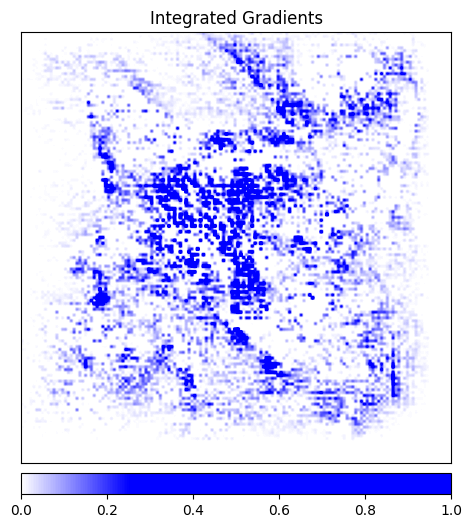

In [54]:
_ = viz.visualize_image_attr(None, np.transpose(input_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)), method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', [(0, "#ffffff"), (0.25, "#0000ff"), (1, "#0000ff")], N=256)

attr_img = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
org_img = np.transpose(input_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0))

_ = viz.visualize_image_attr(attr=attr_img, original_image=org_img, method="heat_map", cmap=default_cmap, show_colorbar=True, sign="positive", title="Integrated Gradients")

**Interpretation of Result:**  
In the second image (the heatmap), darker blue areas indicate pixels that contributed the most to the model's prediction that the input is a 'Cat'. These regions are most important for classifying the image as a 'Cat'.  

Higher intensity blue regions indicate high attribution, meaning those parts of the image had a significant positive influence on the model's decision.  
Lighter areas (whiter regions) indicate less important pixels that contributed minimally to the decision.  

Based on the heatmap, some regions around the cat's face, especially the middle parts (nose, eyes, ears), have high attribution, meaning the model focuses on these regions when predicting 'Cat'. This indicates that the model is looking into the correct regions that should be accounted for making a prediction.  
Through this example, we used integrated gradients to interpret the contribution of input pixels while making the output and saw that the model is performing as expected.

### Layer Attribution

Layer attribution methods focus on understanding how neurons or activations in a specific layer of a neural network contribute to the final prediction. In contrast to input attribution performed above, which explains contributions at the input level (like pixels), layer attribution analyzes the importance of features extracted at deeper layers.  
An example of layer attribution using Layer Grad-CAM is demonstrated below:


### Layer Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visual explanation method that generates class-discriminative localization maps, showing which parts of a specific layer’s activations were most relevant to the model's prediction for a given class.  

The theory behind its working (based on the paper by Selvaraju et al) is explained below:  
Step 1:  
Forward Pass - We compute the activations of a particular layer denoted by $A^L$ by passing the input image across the model.  

Step 2:  
Backward Pass - We then compute the gradients of the models prediction $y$ with respect to $A^L$ -> $\frac{\partial y}{\partial A^L}$  

Step 3:  
Weight Computation - For each feature map k in the layer, we compute a global average pooling over the gradients to obtain a weight $\alpha_k$, which represents the importance of feature map k for the prediction. -> $\alpha_k = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y}{\partial A^L_{i,j,k}}$  

Step 4:  
Weighted Sum - Finally we multiply the feature map $A^L_k$ by its corresponding weight $\alpha_k$, sum over all feature maps to get the Grad-CAM localization map ->  
$L_{\text{Grad-CAM}} = \text{ReLU}\left( \sum_k \alpha_k A^L_k \right)$  


We can understand this better with the help of an example.  
Consider the same image of the cat and the same model from the feature attribution example.  

For layer attribution, we can take the exmaple of the third convolution layer (out of 4 layers) and try to understand the attribution of this layer toward the model's final prediction.  

With `lgc = LayerGradCam(model, target_layer)`, we are initializing the GradCAM object from the camptum library in Pytorch.  

Finally we perform the layer attribution using `attributions_lgc = lgc.attribute()` and the following arguments:  
i. `inputs=input_tensor` representing the input image tensor  
ii. `target=0` specifying the expected prediction as class '0' or 'cat'.  

In [55]:
#We select the second last convolution layer of the model to process
target_layer = model.conv3

#Perform layer attribution
lgc = LayerGradCam(model, target_layer)
attributions_lgc = lgc.attribute(inputs=input_tensor, target=0)
print(f"Input Shape:\n {input_tensor.shape}")
print(f"Attribution Shape:\n {attributions_lgc.shape}")

Input Shape:
 torch.Size([1, 3, 150, 150])
Attribution Shape:
 torch.Size([1, 1, 34, 34])


The attribution result is equal the size of output image from the third convolution layer.  
Hence, it is much smaller than the size of the input image.  

To vizualize this result/map, we use the `viz.visualize_image_attr()` function with the following arguments:  
i. `attr=attr_img` We pass the attribute result converted to a numpy array  
ii. `sign="all"` indicates that both the positive and negative attributions should be included in the vizualization

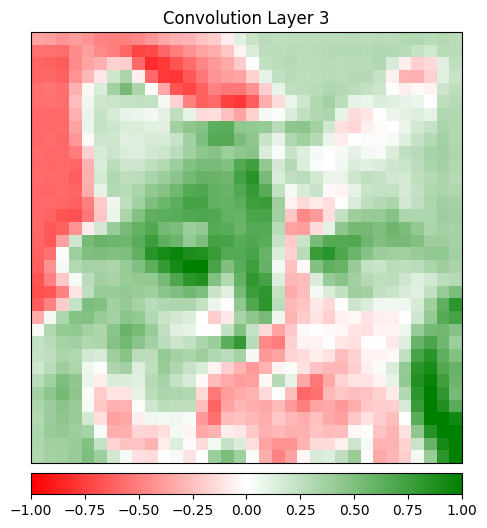

In [56]:
attr_img = attributions_lgc[0].cpu().permute(1,2,0).detach().numpy()
_ = viz.visualize_image_attr(attr=attr_img, sign="all", show_colorbar=True, title="Convolution Layer 3")

The output shows the vizualization of the neurons attributing to the final prediction in the form of green and red values. The more intense the color, the stronger the contribution (positive or negative) of that region to the model's prediction.  

The green areas have positive attributions, meaning that the neurons in these regions of the feature maps contributed positively to the prediction of the target class (i.e., 'Cat'). The green areas likely correspond to regions of the image that the model used as evidence for classifying it as a 'Cat', such as the facial features including the eyes and nose. There are some neurons from the background contributing positively as well, but their amplitude is very small.  

The red areas have negative attributions, meaning that the neurons in these regions contributed negatively to the prediction of the target class. The model might have seen these regions as less relevant for the target class or as potential evidence for the other class (e.g., 'Dog').  

**Upsampled Masked Vizualization**  
Since the resultant Grad-CAM output is smaller than the input image, we can upsample it to matcch the input tensor shape using the interpolate method - `LayerAttribution.interpolate()` and setting `interpolate_dims=150`.  
This allows us to view the positive attributions masked on top of the image for a clearer understanding of the Layer Grad-CAM algorithm result.  

We achieve the masking using the `viz.visualize_image_attr_multiple()` method with the following arguments:  
i. `methods=["original_image", "blended_heat_map", "masked_image"]` - we want to display 3 images, namely the original input image, the blended heatmap with the upsampled attribute alongside the input, and finally the masked input image with the area governed by the positive attributes represented by black pixels.  
ii. `signs=["all", "positive", "negative"]` to indicate that we want both positive and negative attributions in the original image, only positive in the second image, and only negative attributions highlighted in the third image.  

Attribution Shape:
 torch.Size([1, 1, 34, 34])
Upsampled Shape:
 torch.Size([1, 1, 150, 150])
Input Shape:
 torch.Size([1, 3, 150, 150])


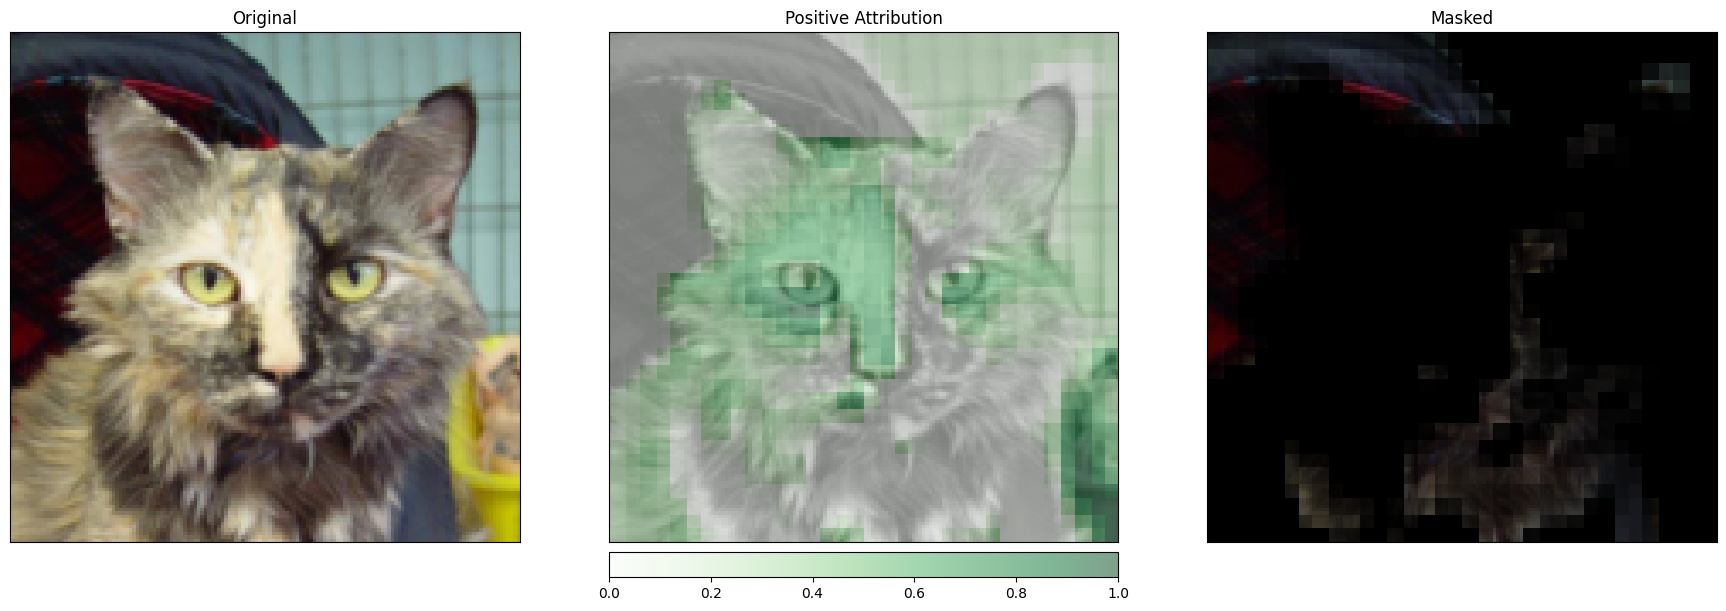

In [61]:
#Upsample the image
up_attr_lgc = LayerAttribution.interpolate(layer_attribution=attributions_lgc, interpolate_dims=input_tensor.shape[2:])

print(f"Attribution Shape:\n {attributions_lgc.shape}")
print(f"Upsampled Shape:\n {up_attr_lgc.shape}")
print(f"Input Shape:\n {input_tensor.shape}")

up_img = up_attr_lgc[0].cpu().permute(1, 2, 0).detach().numpy()
in_img = input_tensor[0].cpu().permute(1, 2, 0).detach().numpy()

_ = viz.visualize_image_attr_multiple(attr=up_img, original_image=in_img, methods=["original_image", "blended_heat_map", "masked_image"], signs=["all", "positive", "negative"], show_colorbar=True, titles=["Original", "Positive Attribution", "Masked"], fig_size=(18, 6))

The upsampled image size showed that the attribution image is now the same size as the input image.  

From the above results, we can clearly see the positive attributions on top of the input image.  
From the second image, the othline of the cat and the facial features are clearly marked in green resulting in expected behavior.  
From the third image, the masked out region leaves very few important pixels and also highlights that the red region behind the cat is not favorable for the prediction of this image to be a cat.

Overall, we can see that the visualization for layer Grad-CAM highlights the efficiency of the 3rd convolutional layer in focussing toward specific regions (facial features) that are highly indicative of the target class, while discounting or opposing irrelevant parts (background or non-cat-related textures).  
This example allowed us to confirm using Layer Grad-CAM that the model is behaving as expected.